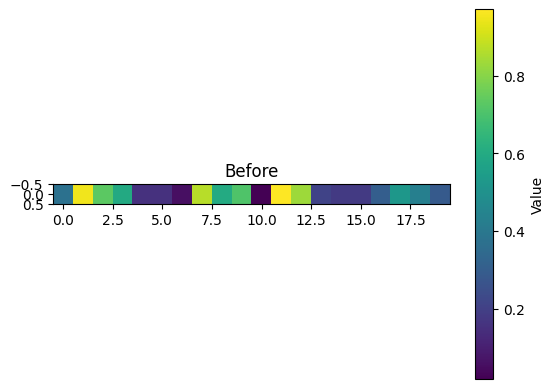

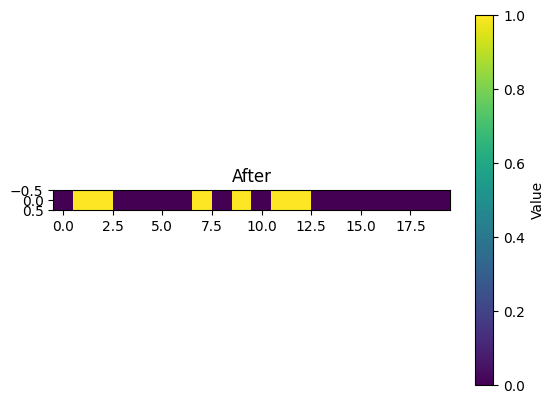

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# set seed for randomness
np.random.seed(42)
test_array = np.random.rand(1, 20)
plt.imshow(test_array, cmap = "viridis", aspect = "equal", interpolation = "nearest")

# below 0.7 set to 0 above set to  1
plt.colorbar(label="Value")
plt.title("Before")
plt.show()

binary_array = np.zeros_like(test_array)
np.greater(test_array, 0.7, out=binary_array)

# Plot as a 1x50 pixel grid
plt.imshow(binary_array, cmap="viridis", aspect = "equal", interpolation="nearest")
plt.colorbar(label="Value")  # optional, shows 0/1
plt.title("After")
plt.show()

In [2]:
binary_array[:,-1] = 1

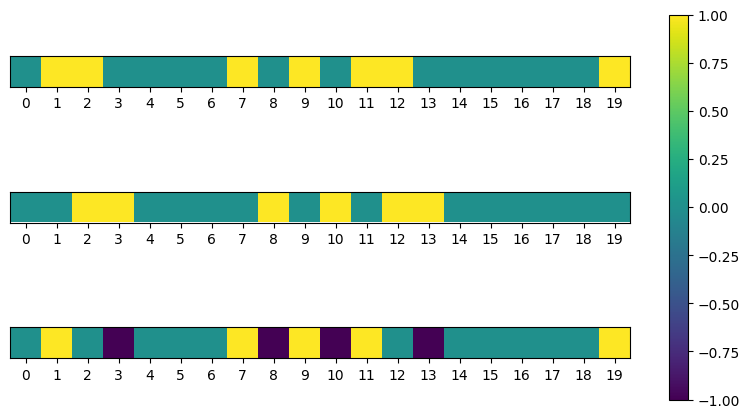

In [3]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(10, 5))

def consolidate_1d(b: np.ndarray, max_gap: int) -> np.ndarray:
    idx = np.flatnonzero(b)
    if idx.size == 0:
        return b.copy()
    cuts = np.where(np.diff(idx) > max_gap)[0]
    starts = np.r_[idx[0], idx[cuts + 1]]
    ends   = np.r_[idx[cuts], idx[-1]]
    diff = np.zeros(b.size + 1, dtype=int)
    np.add.at(diff, starts, 1)
    np.add.at(diff, ends + 1, -1)
    return np.cumsum(diff[:-1]) > 0


# set x labels to be integers going up by one 
axs[0].set_xticks(np.arange(0, 20, 1))
axs[1].set_xticks(np.arange(0, 20, 1))
axs[2].set_xticks(np.arange(0, 20, 1))
axs[0].set_yticks([])
axs[1].set_yticks([])
axs[2].set_yticks([])
binary_array[-1]

# Display the binary array with colorbar from -1 to 1
img = axs[0].imshow(binary_array, cmap="viridis", aspect="equal", interpolation="nearest", vmin=-1, vmax=1)

# Shift the boolean values to the right by one
shifted_array = np.roll(binary_array, shift=1, axis=1)
shifted_array[0,0] = 0  # Set the first element to 0 after the shift
img = axs[1].imshow(shifted_array, cmap="viridis", aspect="equal", interpolation="nearest", vmin=-1, vmax=1)

difference_array = binary_array - shifted_array
img = axs[2].imshow(difference_array, cmap="viridis", aspect="equal", interpolation="nearest", vmin=-1, vmax=1)

# Add a colorbar that spans the entire figure
fig.colorbar(img, ax=axs, orientation='vertical')

plt.show()

Consolidation took 0.000216 seconds


/var/folders/c0/vw8qk1r12ls3wbl2nq_z5cx00000gn/T/ipykernel_23852/2768822764.py:58: UserWarning: Adding colorbar to a different Figure <Figure size 1000x500 with 4 Axes> than <Figure size 1000x600 with 4 Axes> which fig.colorbar is called on.
  fig.colorbar(img, ax=axs, orientation='vertical')


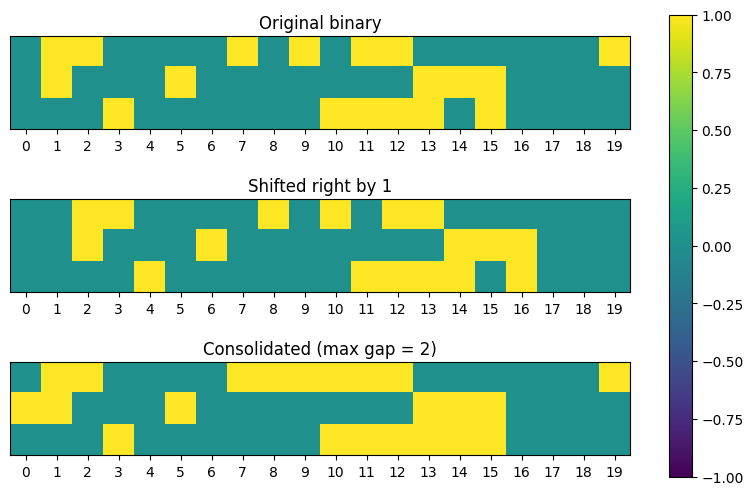

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Example binary array
np.random.seed(42)
test_array = np.random.rand(3, 20)
binary_array = (test_array >= 0.7).astype(int)
binary_array[0,-1] =1
binary_array[1,1] =1

def consolidate_1d(b: np.ndarray, max_gap: int) -> np.ndarray:

    idx = np.flatnonzero(b)
    if idx.size == 0:
        return b.copy()
    cuts = np.where(np.diff(idx) > max_gap)[0]
    starts = np.r_[idx[0], idx[cuts + 1]]
    ends   = np.r_[idx[cuts], idx[-1]]
    diff = np.zeros(b.size + 1, dtype=int)
    np.add.at(diff, starts, 1)
    np.add.at(diff, ends + 1, -1)
    return np.cumsum(diff[:-1]) > 0

# Consolidate with max gap = 2
start_time = time.time()
consolidated = consolidate_1d(binary_array.ravel(), max_gap=2).reshape(binary_array.shape)
end_time = time.time()
print(f"Consolidation took {end_time - start_time:.6f} seconds")

fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(10, 6))

# set x labels to be integers going up by one 
for ax in axs:
    ax.set_xticks(np.arange(0, 20, 1))
    ax.set_yticks([])

# Original
axs[0].imshow(binary_array, cmap="viridis", aspect="equal", interpolation="nearest", vmin=-1, vmax=1)
axs[0].set_title("Original binary")

# Shifted
shifted_array = np.roll(binary_array, shift=1, axis=1)
shifted_array[0,0] = 0
axs[1].imshow(shifted_array, cmap="viridis", aspect="equal", interpolation="nearest", vmin=-1, vmax=1)
axs[1].set_title("Shifted right by 1")

# Difference
# difference_array = binary_array - shifted_array
# axs[2].imshow(difference_array, cmap="viridis", aspect="equal", interpolation="nearest", vmin=-1, vmax=1)
# axs[2].set_title("Difference")

# Consolidated
axs[2].imshow(consolidated, cmap="viridis", aspect="equal", interpolation="nearest", vmin=-1, vmax=1)
axs[2].set_title("Consolidated (max gap = 2)")

# Add a single colorbar spanning all subplots
fig.colorbar(img, ax=axs, orientation='vertical')

# plt.tight_layout()
plt.show()


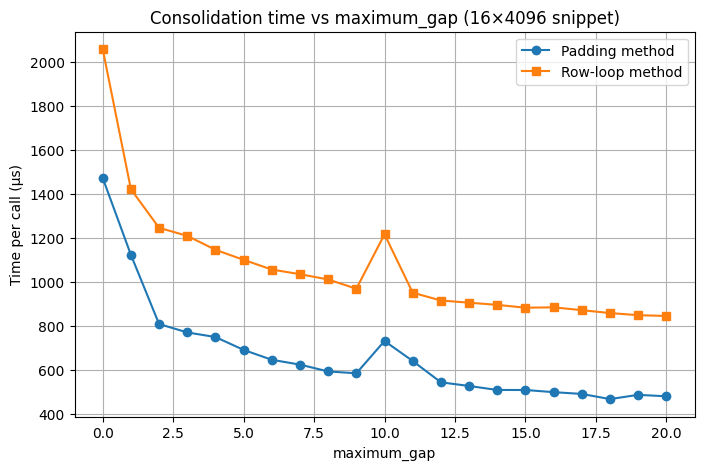

In [42]:
# =====================================================
# Benchmark padding vs row-loop methods across max_gap
# =====================================================

import numpy as np
import time
import matplotlib.pyplot as plt

def consolidate_1d(mask_1d: np.ndarray, maximum_gap: int) -> np.ndarray:
    """
    Merge 1-runs in a 1D boolean/integer mask by filling gaps of length <= maximum_gap.
    Returns a boolean 1D array with consolidated runs.
    """
    b = mask_1d.astype(np.uint8, copy=False).ravel()                 # 0/1 ints
    if b.size == 0 or b.sum() == 0:
        return np.zeros_like(b, dtype=bool)

    d = np.diff(b, prepend=0, append=0)                              # +1 at starts, -1 at ends+1
    starts = np.flatnonzero(d == 1)                                   # run starts
    ends   = np.flatnonzero(d == -1) - 1                              # inclusive run ends

    if starts.size == 0:
        return np.zeros_like(b, dtype=bool)

    gaps = (starts[1:] - ends[:-1]) - 1                               # zeros between consecutive runs
    cuts = np.where(gaps > maximum_gap)[0]                            # split positions between runs

    # ✅ Correct split mapping:
    #   - segment starts: first start, then starts[i+1] for each split at gaps[i]
    #   - segment ends  : ends[i] for each split at gaps[i], then the final end
    merged_starts = np.r_[starts[0], starts[cuts + 1]]
    merged_ends   = np.r_[ends[cuts], ends[-1]]

    diffbuf = np.zeros(b.size + 1, dtype=np.int32)
    np.add.at(diffbuf, merged_starts, 1)
    np.add.at(diffbuf, merged_ends + 1, -1)
    return np.cumsum(diffbuf[:-1]) > 0

def consolidate_rows_with_padding(mask_2d: np.ndarray, maximum_gap: int) -> np.ndarray:
    """
    Consolidate horizontally per row using a single 1D pass with row separators (no row loop).
    Inserts (maximum_gap+1) zeros after each row to prevent cross-row merges, then drops them.
    """
    rows, cols = mask_2d.shape
    sep = maximum_gap + 1
    work = np.zeros((rows, cols + sep), dtype=bool)
    work[:, :cols] = mask_2d.astype(bool, copy=False)
    flat = work.ravel()                                               # view
    cons_flat = consolidate_1d(flat, maximum_gap)
    return cons_flat.reshape(rows, cols + sep)[:, :cols]

def consolidate_rows_loop(mask_2d: np.ndarray, maximum_gap: int) -> np.ndarray:
    """
    Consolidate horizontally per row with a tiny Python loop (each row vectorised).
    """
    rows, cols = mask_2d.shape
    out = np.empty_like(mask_2d, dtype=bool)
    diffbuf = np.zeros(cols + 1, dtype=np.int32)
    for R in range(rows):                                             # 16 iterations -> trivial overhead
        b = mask_2d[R].astype(np.uint8, copy=False)
        if b.sum() == 0:
            out[R].fill(False)
            continue
        d = np.diff(b, prepend=0, append=0)
        starts = np.flatnonzero(d == 1)
        ends   = np.flatnonzero(d == -1) - 1
        if starts.size == 0:
            out[R].fill(False)
            continue
        gaps = (starts[1:] - ends[:-1]) - 1
        cuts = np.where(gaps > maximum_gap)[0]
        merged_starts = np.r_[starts[0], starts[cuts + 1]]
        merged_ends   = np.r_[ends[cuts], ends[-1]]
        diffbuf.fill(0)
        np.add.at(diffbuf, merged_starts, 1)
        np.add.at(diffbuf, merged_ends + 1, -1)
        out[R] = np.cumsum(diffbuf[:-1]) > 0
    return out

# --- Benchmark setup ---
rng = np.random.default_rng(12345)
rows, cols = 16, 4096
true_prob = 0.10
binary_mask = (rng.random((rows, cols)) < true_prob)

max_gaps = np.arange(0, 21)
times_padding = []
times_loop = []

import tqdm.notebook as tqdm
for g in max_gaps:
    # warm-up per gap
    _ = consolidate_rows_with_padding(binary_mask, g)
    _ = consolidate_rows_loop(binary_mask, g)

    t0 = time.perf_counter()
    out_pad = consolidate_rows_with_padding(binary_mask, g)
    t1 = time.perf_counter()
    out_loop = consolidate_rows_loop(binary_mask, g)
    t2 = time.perf_counter()

    if not np.array_equal(out_pad, out_loop):
        raise AssertionError(f"Mismatch at gap={g}")

    times_padding.append(t1 - t0)
    times_loop.append(t2 - t1)

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(max_gaps, np.array(times_padding)*1e6, 'o-', label="Padding method")
plt.plot(max_gaps, np.array(times_loop)*1e6, 's-', label="Row-loop method")
plt.xlabel("maximum_gap")
plt.ylabel("Time per call (µs)")
plt.title("Consolidation time vs maximum_gap (16×4096 snippet)")
plt.legend()
plt.grid(True)
plt.show()



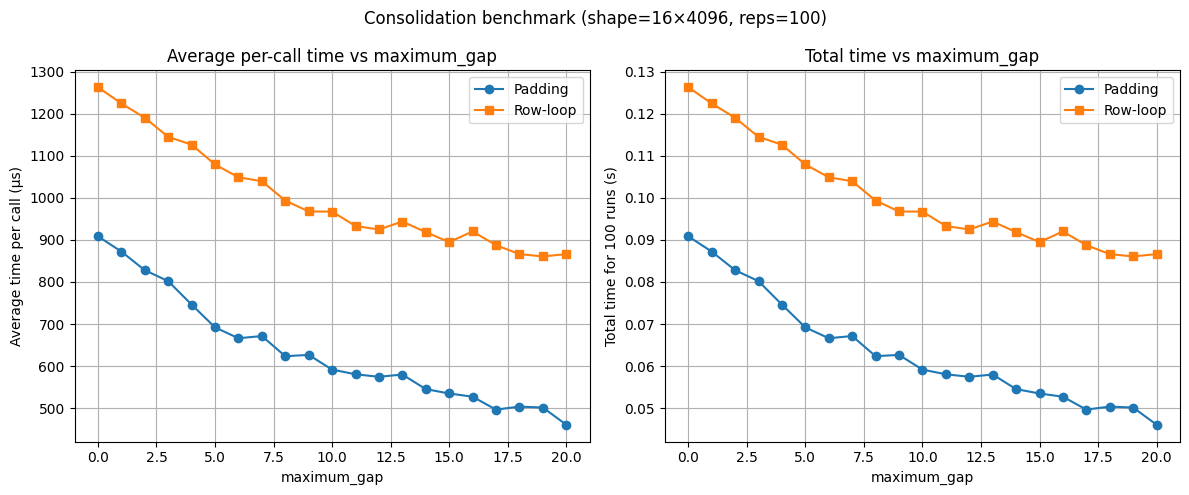

In [44]:
# ============================================================
# Benchmark: padding vs row-loop, 1000 reps per max_gap
# ============================================================

import numpy as np
import time
import matplotlib.pyplot as plt
import gc

# --- Consolidation helpers (same as before) ---

def consolidate_1d(mask_1d: np.ndarray, maximum_gap: int) -> np.ndarray:
    b = mask_1d.astype(np.uint8, copy=False).ravel()
    if b.size == 0 or b.sum() == 0:
        return np.zeros_like(b, dtype=bool)
    d = np.diff(b, prepend=0, append=0)
    starts = np.flatnonzero(d == 1)
    ends   = np.flatnonzero(d == -1) - 1
    if starts.size == 0:
        return np.zeros_like(b, dtype=bool)
    gaps = (starts[1:] - ends[:-1]) - 1
    cuts = np.where(gaps > maximum_gap)[0]
    merged_starts = np.r_[starts[0], starts[cuts + 1]]
    merged_ends   = np.r_[ends[cuts], ends[-1]]
    buf = np.zeros(b.size + 1, dtype=np.int32)
    np.add.at(buf, merged_starts, 1)
    np.add.at(buf, merged_ends + 1, -1)
    return np.cumsum(buf[:-1]) > 0

def consolidate_rows_with_padding(mask_2d: np.ndarray, maximum_gap: int) -> np.ndarray:
    rows, cols = mask_2d.shape
    sep = maximum_gap + 1
    work = np.zeros((rows, cols + sep), dtype=bool)
    work[:, :cols] = mask_2d.astype(bool, copy=False)
    flat = work.ravel()
    cons_flat = consolidate_1d(flat, maximum_gap)
    return cons_flat.reshape(rows, cols + sep)[:, :cols]

def consolidate_rows_loop(mask_2d: np.ndarray, maximum_gap: int) -> np.ndarray:
    rows, cols = mask_2d.shape
    out = np.empty_like(mask_2d, dtype=bool)
    buf = np.zeros(cols + 1, dtype=np.int32)
    for R in range(rows):
        b = mask_2d[R].astype(np.uint8, copy=False)
        if b.sum() == 0:
            out[R].fill(False)
            continue
        d = np.diff(b, prepend=0, append=0)
        starts = np.flatnonzero(d == 1)
        ends   = np.flatnonzero(d == -1) - 1
        if starts.size == 0:
            out[R].fill(False)
            continue
        gaps = (starts[1:] - ends[:-1]) - 1
        cuts = np.where(gaps > maximum_gap)[0]
        ms = np.r_[starts[0], starts[cuts + 1]]
        me = np.r_[ends[cuts], ends[-1]]
        buf.fill(0)
        np.add.at(buf, ms, 1)
        np.add.at(buf, me + 1, -1)
        out[R] = np.cumsum(buf[:-1]) > 0
    return out

# --- Benchmark setup ---
rng = np.random.default_rng(12345)
rows, cols = 16, 4096
true_prob = 0.1
mask = (rng.random((rows, cols)) < true_prob)

max_gaps = np.arange(0, 21)
reps = 100

avg_pad, avg_loop = [], []
tot_pad, tot_loop = [], []

for g in max_gaps:
    # Warm-up
    _ = consolidate_rows_with_padding(mask, g)
    _ = consolidate_rows_loop(mask, g)

    gc.collect(); gc.disable()

    # Padding timings
    t0 = time.perf_counter()
    for _ in range(reps):
        out_pad = consolidate_rows_with_padding(mask, g)
    t1 = time.perf_counter()
    total_pad = t1 - t0

    # Loop timings
    t0 = time.perf_counter()
    for _ in range(reps):
        out_loop = consolidate_rows_loop(mask, g)
    t1 = time.perf_counter()
    total_loop = t1 - t0

    gc.enable()

    if not np.array_equal(out_pad, out_loop):
        raise AssertionError(f"Mismatch at gap={g}")

    tot_pad.append(total_pad)
    tot_loop.append(total_loop)
    avg_pad.append(total_pad / reps * 1e6)   # µs per call
    avg_loop.append(total_loop / reps * 1e6) # µs per call

# --- Plot results ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Average times
axes[0].plot(max_gaps, avg_pad, 'o-', label="Padding")
axes[0].plot(max_gaps, avg_loop, 's-', label="Row-loop")
axes[0].set_xlabel("maximum_gap")
axes[0].set_ylabel("Average time per call (µs)")
axes[0].set_title("Average per-call time vs maximum_gap")
axes[0].grid(True); axes[0].legend()

# Total times
axes[1].plot(max_gaps, tot_pad, 'o-', label="Padding")
axes[1].plot(max_gaps, tot_loop, 's-', label="Row-loop")
axes[1].set_xlabel("maximum_gap")
axes[1].set_ylabel(f"Total time for {reps} runs (s)")
axes[1].set_title("Total time vs maximum_gap")
axes[1].grid(True); axes[1].legend()

plt.suptitle(f"Consolidation benchmark (shape={rows}×{cols}, reps={reps})")
plt.tight_layout()
plt.show()


In [72]:
print(f"{starts=}")
print(f"{ends=}")

starts=(array([0, 0, 0, 0, 1, 1, 2, 2]), array([1, 4, 7, 9, 1, 5, 5, 9]))
ends=(array([0, 0, 0, 0, 1, 1, 2, 2]), array([2, 4, 7, 9, 2, 5, 5, 9]))


In [84]:
print(starts[1][1:])
print(ends[1][:-1])
gaps = (starts[1][1:] - ends[1][:-1]) - 1
print(gaps)

absolute = 

[4 7 9 1 5 5 9]
[2 4 7 9 2 5 5]
[ 1  2  1 -9  2 -1  3]


Vertical pruning took 2.777959


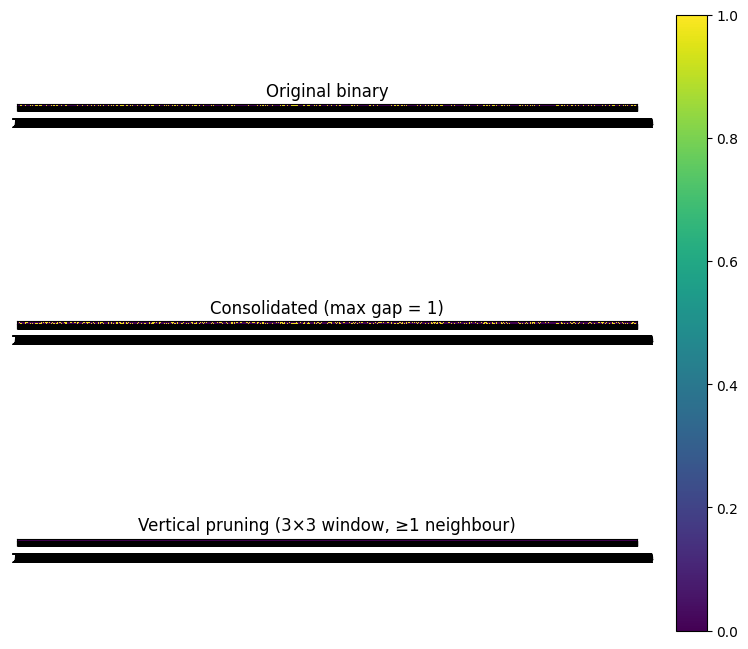

In [22]:
import numpy as np  # numerical computing
import matplotlib.pyplot as plt  # plotting
import time  # timing utilities (optional)

import numpy as np  # numerical computing

def vertical_prune_above_below(
    seed_mask: np.ndarray,
    vertical_half_rows: int = 1,
    horizontal_half_cols: int = 1,
    min_neighbours: int = 1,
    pad_mode: str = "constant",
):
    """
    Keep seeds that have at least `min_neighbours` neighbours in rows strictly
    above/below (±vertical_half_rows) within ±horizontal_half_cols columns.
    The *same row* as the seed is excluded by construction (we sum two rectangles:
    the one above and the one below the centre row).

    Returns
    -------
    pruned_mask : np.ndarray
        Boolean mask of seeds that pass the above+below neighbour test.  # inline comment
    keep_mask : np.ndarray
        Boolean mask of pixels meeting the neighbour threshold (independent of seed status).  # inline comment
    neighbour_count : np.ndarray
        Integer array with counts of neighbours above+below (same row excluded).  # inline comment
    """
    binary_int = seed_mask.astype(np.int32, copy=False)  # cast to int for sums
    number_of_rows, number_of_columns = binary_int.shape  # cache shape
    n = int(vertical_half_rows)  # vertical radius (rows above/below)
    k = int(horizontal_half_cols)  # horizontal radius (columns left/right)
    if n == 0:  # no rows above/below means no neighbours by definition
        neighbour_count = np.zeros_like(binary_int, dtype=np.int32)  # zero neighbours
        keep_mask = neighbour_count >= int(min_neighbours)  # threshold
        pruned_mask = seed_mask.astype(bool) & keep_mask  # apply to seeds only
        return pruned_mask, keep_mask, neighbour_count  # early return

    window_width = 2 * k + 1  # horizontal window width (columns)
    # Pad so every pixel has a full above/below window; then build integral image with a leading zero row/col  # inline comment
    padded = np.pad(binary_int, ((n, n), (k, k)), mode=pad_mode)  # shape: (R+2n, C+2k)
    integral = np.pad(padded, ((1, 0), (1, 0)), mode="constant").cumsum(axis=0).cumsum(axis=1)  # summed-area table

    R, C = number_of_rows, number_of_columns  # aliases for readability

    # Columns slice [C : C+W] vectorised across all C -> implemented as W:W+C vs 0:C in the integral-image space  # inline comment
    c_left = 0  # left index for all positions (relative in the integral image)
    c_right = window_width  # right index offset (exclusive) relative; will be shifted by +C when slicing
    # Above rectangle for each (R,C): rows P[R : R+n], cols P[C : C+W]  -> use integral rows [n : n+R] and [0 : R]  # inline comment
    above_sum = (
        integral[n : n + R, window_width : window_width + C]       # bottom-right
        - integral[0 : R, window_width : window_width + C]          # top-right
        - integral[n : n + R, 0 : C]                                # bottom-left
        + integral[0 : R, 0 : C]                                    # top-left
    )

    # Below rectangle for each (R,C): rows P[R+n+1 : R+2n+1], cols P[C : C+W]
    # -> use integral rows [2n+1 : 2n+1+R] and [n+1 : n+1+R]                                           # inline comment
    below_sum = (
        integral[2 * n + 1 : 2 * n + 1 + R, window_width : window_width + C]  # bottom-right
        - integral[n + 1 : n + 1 + R, window_width : window_width + C]        # top-right
        - integral[2 * n + 1 : 2 * n + 1 + R, 0 : C]                          # bottom-left
        + integral[n + 1 : n + 1 + R, 0 : C]                                  # top-left
    )

    neighbour_count = above_sum + below_sum  # total neighbours strictly above/below
    keep_mask = neighbour_count >= int(min_neighbours)  # threshold to boolean keep
    pruned_mask = seed_mask.astype(bool) & keep_mask  # keep only original seeds that pass
    return pruned_mask, keep_mask, neighbour_count  # outputs




# ============================
# Your original test harness
# ============================


def consolidate_linear(arr: np.ndarray, maximum_gap: int, unique_id: tuple | None = None) -> np.ndarray:
    """
    Merge 1-runs in arr (treated as a single flattened stream) by filling zero-gaps <= maximum_gap.
    Returns a boolean array with the SAME SHAPE as arr. Rows WILL merge across boundaries.
    """
    original_shape = arr.shape  # cache shape

    check_diff = np.diff(arr, axis=1, prepend=0, append=0)  # row-wise differences for debugging
    print(f"{check_diff=}")  # debug print
    starts_debug = np.where(check_diff == 1)  # debug: starts per row
    ends_debug = (np.where(check_diff == -1)[0], np.where(check_diff == -1)[1] - 1)  # debug: ends per row (inclusive)
    print(f"{starts_debug=}", starts_debug[0].shape, starts_debug[1].shape)  # debug shapes
    print(f"{ends_debug=}", ends_debug[0].shape, ends_debug[1].shape)  # debug shapes

    # Flatten-based consolidation below; this intentionally merges across row boundaries.  # inline comment
    flat_uint8 = arr.astype(np.uint8, copy=False).ravel()  # 0/1 flattened
    diff_flat = np.diff(flat_uint8, prepend=0, append=np.array((100, 200, 300)))  # synthetic tail to force closing
    print(f"{diff_flat=}")  # debug
    print(f"{diff_flat.shape=}")  # debug

    starts = np.flatnonzero(diff_flat == 1)  # run starts
    ends = np.flatnonzero(diff_flat == -1) - 1  # run ends (inclusive)

    gaps = (starts[1:] - ends[:-1]) - 1  # zero-run sizes between adjacent 1-runs
    cut_indices = np.where(gaps > maximum_gap)[0]  # indices where we DO NOT merge
    merged_starts = np.r_[starts[0], starts[cut_indices + 1]]  # merged run starts
    merged_ends = np.r_[ends[cut_indices], ends[-1]]  # merged run ends

    difference_buffer = np.zeros(flat_uint8.size + 1, dtype=np.int32)  # diff buffer
    np.add.at(difference_buffer, merged_starts, 1)  # +1 at starts
    np.add.at(difference_buffer, merged_ends + 1, -1)  # -1 after ends
    consolidated_flat = np.cumsum(difference_buffer[:-1]) > 0  # fill with cumsum

    return consolidated_flat.reshape(original_shape)  # reshape back

# Consolidate with max gap = 1
# consolidated = consolidate_linear(binary_array, 1)  # run consolidation on the binary array

# Example binary array
np.random.seed(42)  # seed RNG for reproducibility
test_array = np.random.rand(16, 4096)  # random base array
test_array[-1, -1] = 1  # force a seed bottom-right
binary_array = (test_array >= 0.7).astype(int)  # threshold to 0/1
binary_array[0, -1] = 1  # set a few manual seeds
binary_array[1, 1] = 1  # set a seed
binary_array[1, 5] = 1  # set a seed
binary_array[0, 4] = 1  # set a seed

# Apply VERTICAL pruning (3x3 window -> n=1, k=1) with "at least 1 neighbour" rule
import time 
start_time = time.time()
for i in range(70_000):
    pruned_vertical, keep_mask_vertical, neighbour_count_vertical = vertical_prune_above_below(
        seed_mask=binary_array,  # original seeds
        vertical_half_rows=0,  # +/- 1 row
        horizontal_half_cols=1,  # +/- 1 col
        min_neighbours=1,  # require at least one neighbour (excluding self)
        pad_mode="constant",  # zero padding at edges
    )
end_time = time.time()
print(f"Vertical pruning took {(end_time - start_time):.6f}")



# --- Plot: Original, Consolidated, Vertically-Pruned ---
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10, 8))  # create 3 stacked subplots

for axis in axes:  # common ticks formatting
    axis.set_xticks(np.arange(0, binary_array.shape[1], 1))  # integer x ticks
    axis.set_yticks([])  # hide y ticks

im0 = axes[0].imshow(binary_array, cmap="viridis", aspect="equal", interpolation="nearest", vmin=0, vmax=1)  # original
axes[0].set_title("Original binary")  # title

im1 = axes[1].imshow(binary_array, cmap="viridis", aspect="equal", interpolation="nearest", vmin=0, vmax=1)  # consolidated
axes[1].set_title("Consolidated (max gap = 1)")  # title

im2 = axes[2].imshow(pruned_vertical.astype(int), cmap="viridis", aspect="equal", interpolation="nearest", vmin=0, vmax=1)  # vertical pruned
axes[2].set_title("Vertical pruning (3×3 window, ≥1 neighbour)")  # title

# Add a single colorbar spanning all subplots (use the last image handle)
fig.colorbar(im1, ax=axes, orientation='vertical')  # colorbar for reference

# plt.tight_layout()  # layout
plt.show()  # display


In [46]:
maximum_gap = 
np.zeros(3)

array([0., 0., 0.])

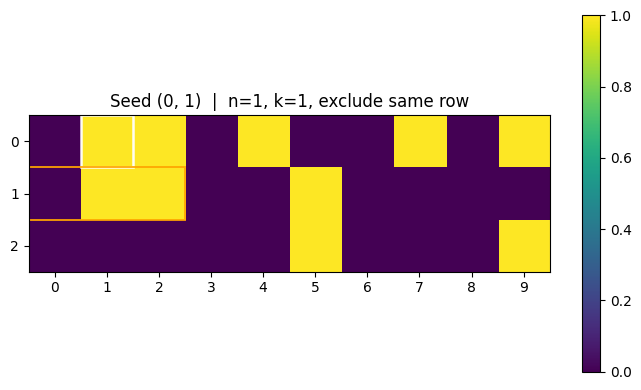

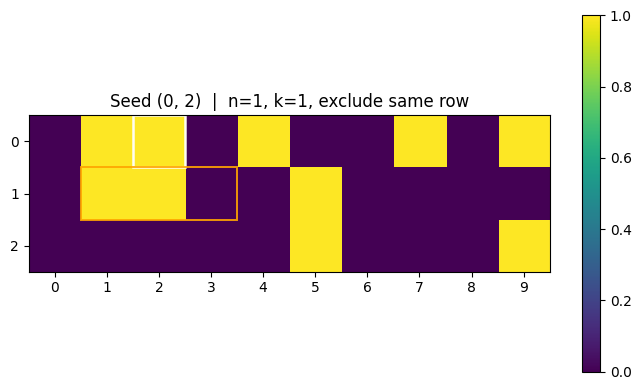

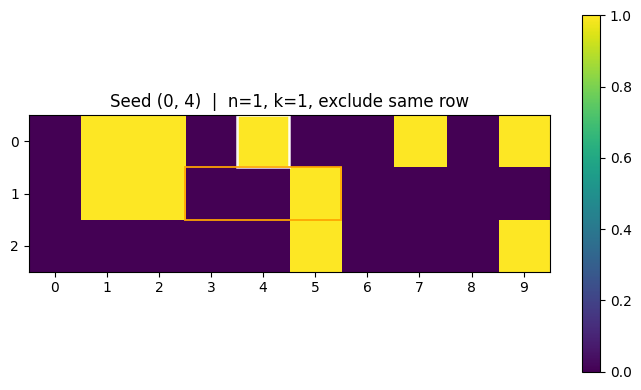

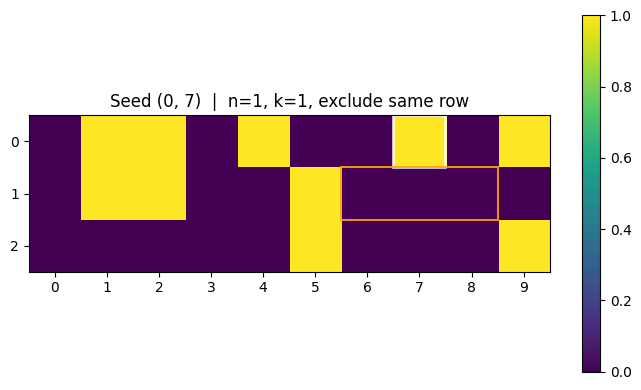

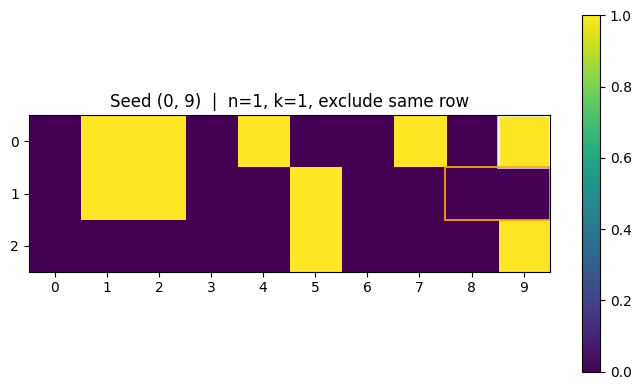

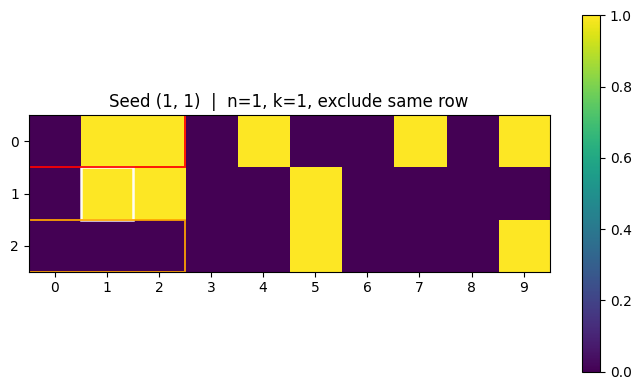

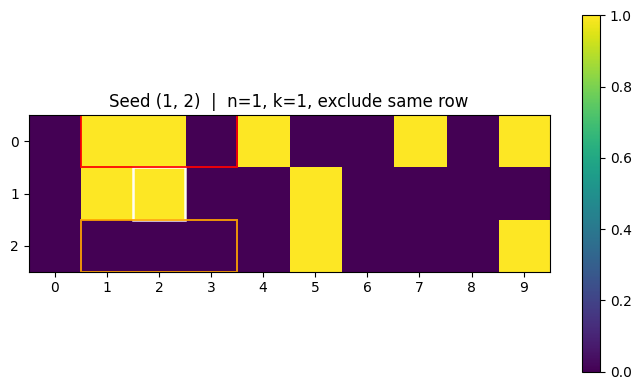

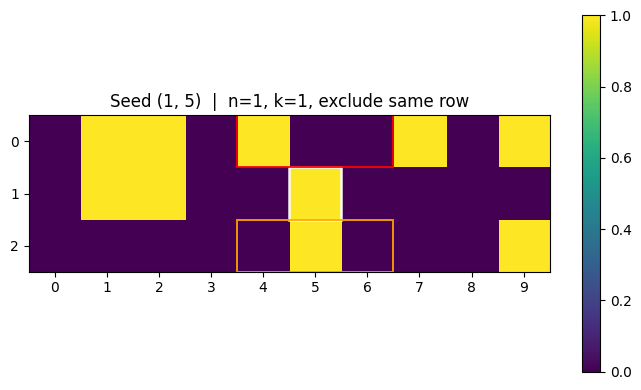

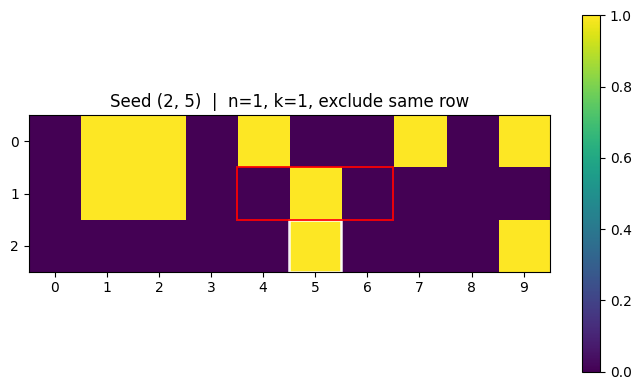

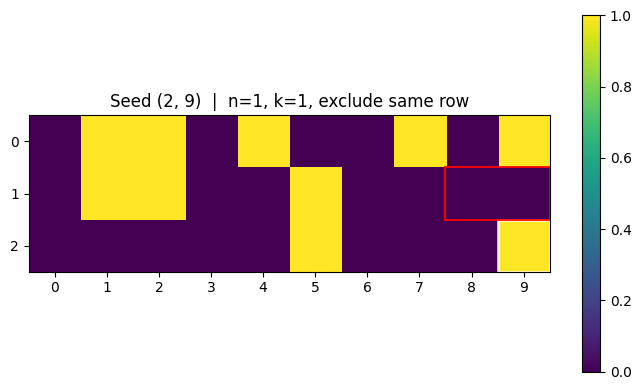

In [21]:
import numpy as np  # numerical computing
import matplotlib.pyplot as plt  # plotting
from matplotlib.patches import Rectangle  # rectangle overlays
from pathlib import Path  # file paths for optional saving


def plot_vertical_windows_each_seed(
    seed_mask: np.ndarray,
    vertical_half_rows: int,
    horizontal_half_cols: int,
    exclude_same_row: bool = True,
    seeds_to_plot: list[tuple[int, int]] | None = None,
    maximum_seeds_to_plot: int = 10,
    random_sample: bool = False,
    figure_size: tuple[int, int] = (7, 4),
    save_directory_path: str | None = None,
) -> None:
    """
    Create one figure per seed showing the exact rectangle(s) checked for that seed.

    - If exclude_same_row=True: draws the ABOVE (red) and BELOW (orange) rectangles only.
    - If exclude_same_row=False: draws the single centred (2n+1)×(2k+1) window (cyan).

    Parameters
    ----------
    seed_mask : np.ndarray
        Binary/boolean 2D array where 1/True marks a seed pixel.  # inline comment
    vertical_half_rows : int
        Vertical radius n (rows above/below).  # inline comment
    horizontal_half_cols : int
        Horizontal radius k (columns left/right).  # inline comment
    exclude_same_row : bool
        If True, ignore the same row entirely (use two rectangles: above and below).  # inline comment
    seeds_to_plot : list[tuple[int,int]] | None
        Explicit list of (row, col) seeds to draw; if None, picks from all seeds.  # inline comment
    maximum_seeds_to_plot : int
        Upper bound on number of figures to produce.  # inline comment
    random_sample : bool
        If True and many seeds, sample without replacement up to the maximum.  # inline comment
    figure_size : tuple[int,int]
        Matplotlib figure size for each plot.  # inline comment
    save_directory_path : str | None
        If provided, saves each figure as PNG into this directory.  # inline comment
    """
    seed_mask_boolean = seed_mask.astype(bool)  # ensure boolean for indexing
    number_of_rows, number_of_columns = seed_mask_boolean.shape  # cache shape
    all_seed_coordinates = list(zip(*np.nonzero(seed_mask_boolean)))  # list of (row, col) seed coordinates

    if not all_seed_coordinates:  # handle no seeds
        print("No seeds found to plot.")  # feedback
        return  # nothing to do

    if seeds_to_plot is None:  # auto-select seeds if not provided
        if random_sample and len(all_seed_coordinates) > maximum_seeds_to_plot:  # random sampling path
            random_generator = np.random.default_rng(0)  # deterministic sampling
            selected_indices = random_generator.choice(len(all_seed_coordinates), size=maximum_seeds_to_plot, replace=False)  # pick indices
            seeds_to_plot = [all_seed_coordinates[i] for i in selected_indices]  # build seed list
        else:  # simple head slice
            seeds_to_plot = all_seed_coordinates[:maximum_seeds_to_plot]  # take first N seeds

    output_directory = None  # initialise save directory holder
    if isinstance(save_directory_path, str):  # if saving is requested
        output_directory = Path(save_directory_path)  # convert to Path
        output_directory.mkdir(parents=True, exist_ok=True)  # create directory if needed

    def add_pixel_aligned_rectangle(axes_object, row_min_inclusive, row_max_inclusive,
                                    col_min_inclusive, col_max_inclusive,
                                    edge_colour, line_style, line_width, alpha_value):  # helper to draw boxes
        """Add a rectangle aligned to pixel edges for visual clarity."""  # docstring
        width_in_pixels = int(col_max_inclusive - col_min_inclusive + 1)  # compute width
        height_in_pixels = int(row_max_inclusive - row_min_inclusive + 1)  # compute height
        rectangle_patch = Rectangle(  # create rectangle
            (col_min_inclusive - 0.5, row_min_inclusive - 0.5),  # lower-left corner at pixel edge
            width_in_pixels,  # rectangle width
            height_in_pixels,  # rectangle height
            fill=False,  # outline only
            linestyle=line_style,  # line style
            linewidth=line_width,  # line width
            edgecolor=edge_colour,  # edge colour
            alpha=alpha_value,  # transparency
        )  # end rectangle
        axes_object.add_patch(rectangle_patch)  # add rectangle to axes

    # loop over seeds and produce one figure per seed
    for seed_row_index, seed_column_index in seeds_to_plot:  # iterate selected seeds
        figure, axes = plt.subplots(figsize=figure_size)  # new figure per seed
        image_handle = axes.imshow(seed_mask_boolean.astype(int), cmap="viridis", interpolation="nearest", vmin=0, vmax=1)  # show seed map
        axes.set_xticks(np.arange(0, number_of_columns, 1))  # integer x ticks
        axes.set_yticks(np.arange(0, number_of_rows, 1))  # integer y ticks
        axes.set_xlim(-0.5, number_of_columns - 0.5)  # x-limits at pixel edges
        axes.set_ylim(number_of_rows - 0.5, -0.5)  # invert y so row 0 is at top
        axes.set_title(  # informative title
            f"Seed ({seed_row_index}, {seed_column_index})  |  n={vertical_half_rows}, k={horizontal_half_cols}, "
            f"{'exclude same row' if exclude_same_row else 'include same row'}"  # mode description
        )  # end title

        # seed marker (white 1×1 box)
        add_pixel_aligned_rectangle(axes, seed_row_index, seed_row_index, seed_column_index, seed_column_index,
                                    edge_colour="white", line_style="-", line_width=1.8, alpha_value=0.95)  # seed highlight

        # compute window bounds clamped to image dimensions
        row_min_centre = max(0, seed_row_index - vertical_half_rows)  # centred window min row
        row_max_centre = min(number_of_rows - 1, seed_row_index + vertical_half_rows)  # centred window max row
        col_min_centre = max(0, seed_column_index - horizontal_half_cols)  # centred window min col
        col_max_centre = min(number_of_columns - 1, seed_column_index + horizontal_half_cols)  # centred window max col

        if exclude_same_row:  # draw above and below rectangles only
            if vertical_half_rows > 0:  # only if at least one row to consider
                # ABOVE rectangle: rows [seed_row_index - n, seed_row_index - 1]
                above_row_min = max(0, seed_row_index - vertical_half_rows)  # top row for above rectangle
                above_row_max = seed_row_index - 1  # bottom row for above rectangle
                if above_row_max >= above_row_min:  # draw only if non-empty
                    add_pixel_aligned_rectangle(axes, above_row_min, above_row_max, col_min_centre, col_max_centre,
                                                edge_colour="red", line_style="-", line_width=1.4, alpha_value=0.9)  # draw above

                # BELOW rectangle: rows [seed_row_index + 1, seed_row_index + n]
                below_row_min = seed_row_index + 1  # top row for below rectangle
                below_row_max = min(number_of_rows - 1, seed_row_index + vertical_half_rows)  # bottom row for below rectangle
                if below_row_max >= below_row_min:  # draw only if non-empty
                    add_pixel_aligned_rectangle(axes, below_row_min, below_row_max, col_min_centre, col_max_centre,
                                                edge_colour="orange", line_style="-", line_width=1.4, alpha_value=0.9)  # draw below
        else:  # include same row: draw centred window box
            add_pixel_aligned_rectangle(axes, row_min_centre, row_max_centre, col_min_centre, col_max_centre,
                                        edge_colour="cyan", line_style="-", line_width=1.4, alpha_value=0.9)  # centred window

        figure.colorbar(image_handle, ax=axes, orientation="vertical")  # add colour bar
        figure.tight_layout()  # clean layout

        if output_directory is not None:  # optionally save figure
            output_path = output_directory / f"seed_r{seed_row_index}_c{seed_column_index}.png"  # file path
            figure.savefig(output_path, dpi=150)  # save PNG
            print(f"Saved: {output_path}")  # notify

        plt.show()  # display this seed’s figure


# ============================
# example usage (one plot per seed, up to 10 seeds)
# ============================

if __name__ == "__main__":  # script guard
    np.random.seed(42)  # seed RNG for reproducibility
    test_array = np.random.rand(3, 10)  # random base array
    test_array[-1, -1] = 1  # force a seed bottom-right
    binary_array = (test_array >= 0.7).astype(int)  # threshold to 0/1
    binary_array[0, -1] = 1  # set a few manual seeds
    binary_array[1, 1] = 1  # set a seed
    binary_array[1, 5] = 1  # set a seed
    binary_array[0, 4] = 1  # set a seed


    # produce up to 10 separate figures (one per seed), above+below rectangles, n=1, k=1
    plot_vertical_windows_each_seed(
        seed_mask=binary_array,  # binary seed mask
        vertical_half_rows=1,  # look one row up and one down
        horizontal_half_cols=1,  # ±1 column tolerance
        exclude_same_row=True,  # ignore same row completely
        seeds_to_plot=None,  # let the function select seeds
        maximum_seeds_to_plot=10,  # cap at 10 figures
        random_sample=False,  # take first N seeds
        figure_size=(7, 4),  # per-figure size
        save_directory_path=None,  # or e.g. "./seed_windows"
    )


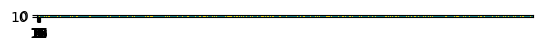

Consolidation took 6.412819 seconds


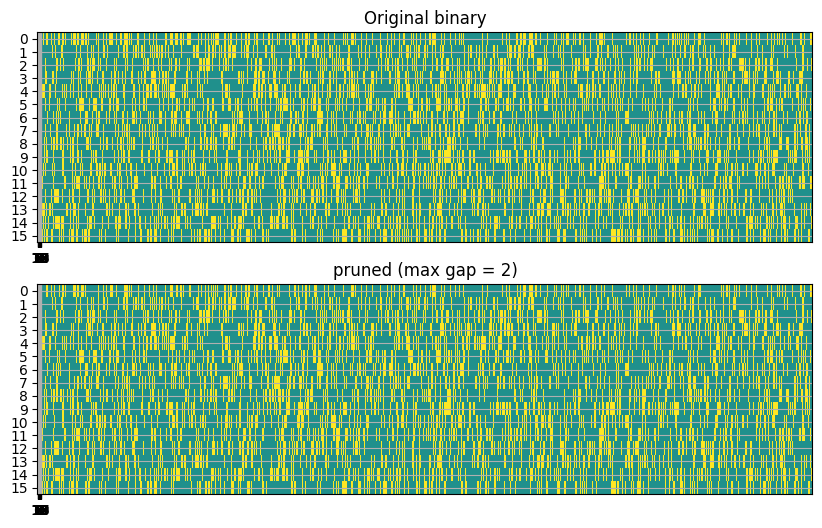

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import njit, prange

@njit(parallel=True)
def scan_surroundings(
    array: np.ndarray,
    pruned_2d: np.ndarray,
    true_indicies: np.ndarray,
    max_horizontal_gap: int,
) -> np.ndarray:

    # make a verified_array where it is starting as a False array
    for i in prange(len(true_indicies)):
        row, col = true_indicies[i]
        left_column_index = max(0, col - max_pixel_distance_either_side)
        right_column_index = min(array.shape[1]-1, col + max_pixel_distance_either_side)

        sum_region = array[row, left_column_index:right_column_index+1].sum()
        # print(f"for point at ({row}, {col}): sum_region = {sum_region}")
        # print(right_column_index - left_column_index, left_column_index, right_column_index)
        if sum_region > 1:
            pruned_2d[row, col] = True
    return pruned_2d
@njit(parallel=True)
def vertical_prune_above_below(array, 
                            pruned_2d, 
                            true_indicies, 
                            vertical_half_rows, 
                            horizontal_half_cols, min_neighbours):
    for i in prange(len(true_indicies)):
        row, col = true_indicies[i]
        count = 0
        left_column_index = max(0, col - horizontal_half_cols)
        right_column_index = min(array.shape[1]-1, col + horizontal_half_cols)

        upper_row_index = max(0, row - vertical_half_rows)
        lower_row_index = min(array.shape[0]-1, row + vertical_half_rows)

        # work out big rectangle - exclude same row
        # big rectangle
        sum_region_big = array[upper_row_index:lower_row_index+1, left_column_index:right_column_index+1].sum()
        sum_region_same_row = array[row, left_column_index:right_column_index+1].sum()
        count = sum_region_big - sum_region_same_row
        if count >= min_neighbours:
            pruned_2d[row, col] = True
    return pruned_2d

def _horizontal_prune(
    array: np.ndarray, max_pixel_distance_either_side: int
) -> np.ndarray:
    """
    Apply horizontal pruning using 1D run detection on the flattened padded mask.
    A pixel is marked True if it is part of a valid run where the gaps between runs
    are <= max_pixel_distance_either_side. Pixels that fall into runs separated by
    larger gaps become False.
    """
    # initial_boolean_mask is where array is larger than threshold 0.8
    initial_boolean_mask = array > 0.8
    number_of_rows, number_of_columns = array.shape  # cache shape

    seperation = max_pixel_distance_either_side + 1  # extra padding to prevent wrap merging

    # print(f"Seperation: {initial_boolean_mask}")

    true_indicies = np.argwhere(array)
    # print(f"true_indicies: {true_indicies}")

    pruned_2d = np.zeros_like(array, dtype=bool)

    # pruned_2d = scan_surroundings(array, pruned_2d, true_indicies=true_indicies, max_horizontal_gap=max_pixel_distance_either_side)
    pruned_2d = vertical_prune_above_below(array, 
                                    pruned_2d, 
                                    true_indicies=true_indicies, 
                                    vertical_half_rows=1,
                                    horizontal_half_cols=max_pixel_distance_either_side,
                                    min_neighbours=1)


    return pruned_2d



# Example binary array
# Example binary array
np.random.seed(42)
test_array = np.random.rand(16, 4096)
binary_array = (test_array >= 0.7).astype(int)
binary_array[0,-1] =1
binary_array[1,1] =1
binary_array[1,3] =1
binary_array[1,4] =1
binary_array[1,5] =0

plt.imshow(binary_array, cmap="viridis", aspect="equal", interpolation="nearest", vmin=-1, vmax=1)
plt.xticks(np.arange(0, 20, 1))
plt.show()

# Consolidate with max gap = 2
start_time = time.time()
for i in range(10_000):
    pruned = _horizontal_prune(binary_array, max_pixel_distance_either_side=2)
end_time = time.time()
print(f"Consolidation took {end_time - start_time:.6f} seconds")

fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10, 6))

# set x labels to be integers going up by one 
for ax in axs:
    ax.set_xticks(np.arange(0, 20, 1))
    ax.set_yticks(np.arange(0, 16, 1))

# Original
axs[0].imshow(binary_array, cmap="viridis", aspect="auto", interpolation="nearest", vmin=-1, vmax=1)
axs[0].set_title("Original binary")
axs[0].grid()
# Difference
# difference_array = binary_array - shifted_array
# axs[2].imshow(difference_array, cmap="viridis", aspect="equal", interpolation="nearest", vmin=-1, vmax=1)
# axs[2].set_title("Difference")

# Consolidated
axs[1].imshow(pruned, cmap="viridis", aspect="auto", interpolation="nearest", vmin=-1, vmax=1)
axs[1].set_title("pruned (max gap = 2)")
# grid both hor and vertical
axs[1].grid(axis = 'both')

# Add a single colorbar spanning all subplots
# fig.colorbar(img, ax=axs, orientation='vertical')

# plt.tight_layout()
plt.show()


In [51]:
0.218649*77000

16835.973

In [53]:
16835.973/60**2


4.676659166666667

In [ ]:
def grow_seeds(self, growth_threshold_above_median: float = 1.0):
    """
    Grow seeds horizontally out to the full contiguous above-threshold region.

    For each row:
        - Define eligible pixels as those where
              signal[row, col] > (row_medians[row] + growth_threshold_above_median)
        - Break eligible into contiguous horizontal runs.
        - Keep (fill) an entire run if that run contains at least one seed pixel
          from the chosen base mask (consolidated > final_pruned > initial).
        - Drop runs that contain no seeds.

    This is done in one vectorized pass using 1D flattening with row padding to
    avoid wraparound between rows.

    Result is stored in self.grown_seed_mask and also returned.
    """

    seed_mask_type = "consolidated"
    if self.consolidated_group_boolean_mask is None:
        print("Warning: Consolidated group boolean mask has not been computed yet.")
        print("Will first attempt to consolidate seeds using final pruned mask.")
        seed_mask_type = "final_pruned"
        if self.final_pruned_mask is None:
            print("Warning: Final pruned mask has not been computed yet. So will use initial boolean mask instead.")

            seed_mask_type = "initial"
            if self.initial_boolean_mask is None:
                raise ValueError(
                    "Initial boolean mask must be computed before growing seeds. You must have at least one seed to grow from."
                )
    if seed_mask_type == "consolidated":
        seed_mask = self.consolidated_group_boolean_mask.copy()
    elif seed_mask_type == "final_pruned":
        seed_mask = self.final_pruned_mask.copy()
    elif seed_mask_type == "initial":  # initial
        seed_mask = self.initial_boolean_mask.copy()
    else:
        raise ValueError(f"Unknown seed mask type: {seed_mask_type}")

    
    # ---------- build the eligibility mask based on intensity threshold ----------
    # per-row threshold: median[row] + growth_threshold_above_median
    # shape (rows, 1) so it broadcasts across columns
    growth_thresholds = self.row_medians[:, None] + growth_threshold_above_median
    eligible_mask = self.signal_snippet > growth_thresholds  # shape (Rows, Columns), bool

    # We only care about eligible pixels; we'll later keep only the eligible runs
    # that intersect at least one True in seed_mask.

    # ---------- pad each row with one False column to break adjacency between rows ----------
    # so runs never connect across row boundaries when flattened.

    padded_len = self.number_of_columns + 1 # single-column separator of zeros between rows in the flattened view

    # allocate padded arrays
    padded_eligible = np.zeros((self.number_of_rows, padded_len), dtype=np.bool_)
    padded_seeds    = np.zeros((self.number_of_rows, padded_len), dtype=np.bool_)

    padded_eligible[:, :self.number_of_columns] = eligible_mask
    padded_seeds[:,    :self.number_of_columns] = seed_mask

    # flatten
    flat_eligible = padded_eligible.ravel()  # 1D bool
    flat_seeds    = padded_seeds.ravel()     # 1D bool

    # ---------- find contiguous runs of eligible==True in the flattened array ----------
    # Similar method as that in _consolidate_flattened_rows.
    # diff on flat_eligible to get run starts (+1) and run ends (-1).
    diff = np.diff(flat_eligible.astype(np.uint8), prepend=0, append=0)
    run_starts = np.flatnonzero(diff == 1)  # these have value +1
    run_ends   = np.flatnonzero(diff == -1) - 1  # these have value -1; inclusive ends

    # If there are no eligible runs, growth mask is just the original seed mask.
    if run_starts.size == 0:
        print("Warning: No eligible runs found for seed growth; returning original seed mask.")
        grown_mask = seed_mask.copy()
        self.grown_seed_mask = grown_mask
        return grown_mask

    # ---------- for each run, decide if it contains at least one seed ----------
    # We'll use a prefix sum over flat_seeds to query "any seeds in [start:end]"
    prefix_seeds = np.cumsum(flat_seeds.astype(np.int32))

    # For a run [a, b] inclusive, number of seeds in it is:
    #   prefix_seeds[b] - prefix_seeds[a-1]  (careful at a==0) as it is the number of seeds up to b minus those up to a-1
    # We'll vectorize that:
    left_vals = np.zeros_like(run_starts, dtype=np.int32)
    left_vals[run_starts > 0] = prefix_seeds[run_starts[run_starts > 0] - 1] 

    seeds_in_run = (prefix_seeds[run_ends] - left_vals) > 0  # bool per run > 0 
    # above is the calculation of seeds in each run prefix_seeds[run_ends] is the number of seeds up to the end of each run
    # left_vals is the number of seeds up to the start of each run -1 (or 0 if start is 0)

    # ---------- now build a new flat mask that keeps only runs that had seeds ----------
    flat_grown = np.zeros_like(flat_eligible, dtype=np.bool_)

    # We'll "paint" in only the runs that contain at least one seed.
    # We can do this with a difference buffer like in consolidation.
    diffbuf = np.zeros(flat_eligible.size + 1, dtype=np.int32)

    # Add +1 at run_starts and -1 at run_ends+1 (+1 here for inclusive ends) BUT ONLY for runs with seeds.
    valid_starts = run_starts[seeds_in_run]
    valid_ends   = run_ends[seeds_in_run]

    np.add.at(diffbuf, valid_starts, 1)
    np.add.at(diffbuf, valid_ends + 1, -1)

    # prefix sum to fill in the kept runs
    flat_grown = (np.cumsum(diffbuf[:-1]) > 0)

    # ---------- reshape back to (self.number_of_rows, padded_len), then crop off the separator col ----------
    grown_padded = flat_grown.reshape(self.number_of_rows, padded_len)
    grown_mask = grown_padded[:, :self.number_of_columns]

    # ---------- store and return ----------
    grown_mask |= seed_mask  # ensure original seeds are kept
    self.grown_seed_mask = grown_mask
    return grown_mask
